In [1]:
import numpy as np

# Define the potential functions for each clique. Here we use simple functions for demonstration.
def psi1(x1, x2):
    return np.exp(-abs(x1 - x2))

def psi2(x2, x3):
    return np.exp(-abs(x2 - x3))

# List all configurations of X1, X2, X3
configurations = [(x1, x2, x3) for x1 in [0, 1] for x2 in [0, 1] for x3 in [0, 1]]

# Compute the partition function Z
Z = 0
for config in configurations:
    x1, x2, x3 = config
    prob = psi1(x1, x2) * psi2(x2, x3)
    Z += prob

# Compute the joint probability distribution
joint_probabilities = {}
for config in configurations:
    x1, x2, x3 = config
    prob = psi1(x1, x2) * psi2(x2, x3) / Z
    joint_probabilities[config] = prob

# Output the results
prob_total = 0
for config, prob in joint_probabilities.items():
    prob_total += prob
    print(f"Probability of {config}: {prob:.4f}")

print(prob_total)

Probability of (0, 0, 0): 0.2672
Probability of (0, 0, 1): 0.0983
Probability of (0, 1, 0): 0.0362
Probability of (0, 1, 1): 0.0983
Probability of (1, 0, 0): 0.0983
Probability of (1, 0, 1): 0.0362
Probability of (1, 1, 0): 0.0983
Probability of (1, 1, 1): 0.2672
1.0


In [2]:
import numpy as np

# Define the potential functions for each clique
def psi1(x1, x2):
    return np.exp(-abs(x1 - x2))

def psi2(x2, x3):
    return np.exp(-abs(x2 - x3))

# List all configurations of X1, X2, X3
configurations = [(x1, x2, x3) for x1 in [0, 1] for x2 in [0, 1] for x3 in [0, 1]]

# Compute the partition function Z
Z = 0
joint_probabilities = {}
for config in configurations:
    x1, x2, x3 = config
    prob = psi1(x1, x2) * psi2(x2, x3)
    joint_probabilities[config] = prob
    Z += prob

# Compute marginals
marginals = {
    'X1': np.zeros(2),
    'X2': np.zeros(2),
    'X3': np.zeros(2),
    'X1_X2': np.zeros((2, 2)),
    'X2_X3': np.zeros((2, 2))
}

for (x1, x2, x3), joint_prob in joint_probabilities.items():
    joint_prob /= Z  # Normalize the joint probability
    marginals['X1'][x1] += joint_prob
    marginals['X2'][x2] += joint_prob
    marginals['X3'][x3] += joint_prob
    marginals['X1_X2'][x1, x2] += joint_prob
    marginals['X2_X3'][x2, x3] += joint_prob

# Output the results
for var, dist in marginals.items():
    if dist.ndim == 1:
        for i in range(len(dist)):
            print(f"Marginal P({var}={i}): {dist[i]:.4f}")
    else:
        for i in range(dist.shape[0]):
            for j in range(dist.shape[1]):
                print(f"Marginal P({var}=({i}, {j})): {dist[i, j]:.4f}")

Marginal P(X1=0): 0.5000
Marginal P(X1=1): 0.5000
Marginal P(X2=0): 0.5000
Marginal P(X2=1): 0.5000
Marginal P(X3=0): 0.5000
Marginal P(X3=1): 0.5000
Marginal P(X1_X2=(0, 0)): 0.3655
Marginal P(X1_X2=(0, 1)): 0.1345
Marginal P(X1_X2=(1, 0)): 0.1345
Marginal P(X1_X2=(1, 1)): 0.3655
Marginal P(X2_X3=(0, 0)): 0.3655
Marginal P(X2_X3=(0, 1)): 0.1345
Marginal P(X2_X3=(1, 0)): 0.1345
Marginal P(X2_X3=(1, 1)): 0.3655


In [3]:
import torch

def normalize(tensor):
    return tensor / tensor.sum()

def compute_marginals(A1B, A2C, BD, CD, CE, DEF):

    # Marginalize over A1-B to get marginals for A1 and B
    marginal_A1 = normalize(A1B.sum(dim=1))
    marginal_B = normalize(A1B.sum(dim=0))

    # Marginalize over A2-C to get marginals for A2 and C
    marginal_A2 = normalize(A2C.sum(dim=1))
    marginal_C = normalize(A2C.sum(dim=0))

    # Marginalize over B-D to get marginal for D (B is already marginalized)
    marginal_BD = torch.matmul(marginal_B.view(1, -1), BD)
    marginal_D_from_BD = normalize(marginal_BD.sum(dim=0))

    # Integrate new factor CD
    marginal_CD = torch.matmul(marginal_C.view(1, -1), CD)
    marginal_D_from_CD = normalize(marginal_CD.sum(dim=0))

    # Combine the marginals for D from BD and CD
    marginal_D_combined = normalize(marginal_D_from_BD * marginal_D_from_CD)

    # Marginalize over C-E to get marginal for E (C is already marginalized)
    marginal_CE = torch.matmul(marginal_C.view(1, -1), CE)
    marginal_E = normalize(marginal_CE.sum(dim=0))

    # For the factor DEF, properly reshape and perform marginalization
    DEF_reshaped = DEF.view(2, 2, 2)  # Ensure DEF is reshaped to 2x2x2 tensor
    marginal_F = normalize(DEF_reshaped.sum(dim=0).sum(dim=0))
    marginal_DE = normalize(DEF_reshaped.sum(dim=2))

    marginal_D_from_DEF = normalize(marginal_DE.sum(dim=1))
    marginal_E_from_DEF = normalize(marginal_DE.sum(dim=0))

    marginal_D_final = normalize(marginal_D_combined * marginal_D_from_DEF)
    marginal_E_final = normalize(marginal_E * marginal_E_from_DEF)

    # Marginals for variables A1, A2, B, C, D, E, F
    marginals = {
        "A1": marginal_A1,
        "A2": marginal_A2,
        "B": marginal_B,
        "C": marginal_C,
        "D": marginal_D_final,
        "E": marginal_E_final,
        "F": marginal_F
    }

    return marginals

In [4]:
def compute_posteriors(A1B, A2C, BD, CD, CE, DEF):
    # Initialize the message dimensions
    # Messages from variables to factors and factors to variables
    # m_A1B_A1 = torch.ones(2)
    # m_A1B_B = torch.ones(2)
    # m_A2C_A2 = torch.ones(2)
    # m_A2C_C = torch.ones(2)
    # m_BD_B = torch.ones(2)
    # m_BD_D = torch.ones(2)
    # m_CD_C = torch.ones(2)
    # m_CD_D = torch.ones(2)
    # m_CE_C = torch.ones(2)
    # m_CE_E = torch.ones(2)
    # m_DEF_D = torch.ones(2)
    # m_DEF_E = torch.ones(2)
    # m_DEF_F = torch.ones(2)

    # # Assume a fixed number of iterations for message updates
    # for _ in range(10):
    #     # Update messages for each variable
    #     m_A1B_B = torch.einsum('ij,i->j', A1B, m_A1B_A1)
    #     m_A2C_C = torch.einsum('ij,i->j', A2C, m_A2C_A2)
    #     m_BD_B = torch.einsum('ij,j->i', BD, m_BD_D)
    #     m_BD_D = torch.einsum('ij,i->j', BD, m_BD_B)
    #     m_CD_C = torch.einsum('ij,j->i', CD, m_CD_D)
    #     m_CD_D = torch.einsum('ij,i->j', CD, m_CD_C)
    #     m_CE_C = torch.einsum('ij,j->i', CE, m_CE_E)
    #     m_CE_E = torch.einsum('ij,i->j', CE, m_CE_C)
        
    #     # D=1 observed, so fix m_DEF_D at index 1
    #     m_DEF_D = torch.tensor([0.0, 1.0])

    #     # Update messages for DEF factor, considering D is observed as 1
    #     m_DEF_E = torch.einsum('ijk,j->ik', DEF, m_DEF_D).sum(dim=1)
    #     m_DEF_F = torch.einsum('ijk,j->ik', DEF, m_DEF_D).sum(dim=0)

    # # Compute marginals for each variable by combining incoming messages
    # marginal_A1 = m_A1B_A1  # Only one connection
    # marginal_A2 = m_A2C_A2  # Only one connection
    # marginal_B = m_A1B_B * m_BD_B
    # marginal_C = m_A2C_C * m_CD_C * m_CE_C
    # marginal_D = m_BD_D * m_CD_D * m_DEF_D
    # marginal_E = m_CE_E * m_DEF_E
    # marginal_F = m_DEF_F

    # # Normalize the marginals to make them valid probabilities
    # marginal_A1 /= marginal_A1.sum()
    # marginal_A2 /= marginal_A2.sum()
    # marginal_B /= marginal_B.sum()
    # marginal_C /= marginal_C.sum()
    # marginal_D /= marginal_D.sum()  # Should be [0, 1] since D=1 is observed
    # marginal_E /= marginal_E.sum()
    # marginal_F /= marginal_F.sum()

    # marginals_given_D1 = {
    #     "A1": marginal_A1,
    #     "A2": marginal_A2,
    #     "B": marginal_B,
    #     "C": marginal_C,
    #     "D": torch.tensor([0, 1]),  # Should be [0, 1] since D=1 is observed
    #     "E": marginal_E,
    #     "F": marginal_F
    # }

    # return marginals_given_D1

    #--------------------------------------------------------------------
    # # To compute the marginals given that D=1, we need to modify our factor tables to account for this evidence
    # # We set the potentials involving D=0 to zero

    # Modify the BD factor to account for D=1 evidence
    BD_evidence = BD.clone()
    BD_evidence[:, 0] = 0  # Setting potentials for D=0 to zero

    # Modify the CD factor to account for D=1 evidence
    CD_evidence = CD.clone()
    CD_evidence[:, 0] = 0  # Setting potentials for D=0 to zero

    # Modify the DEF factor to account for D=1 evidence
    DEF_evidence = DEF.clone()
    DEF_evidence[:, 0:2] = 0  # Setting potentials for D=0 to zero

    # Proceed to compute the marginals with the updated factors

    # Marginalize over B-D to get marginal for B (D is observed)
    marginal_B_given_D1 = normalize(BD_evidence.sum(dim=1))

    # Marginalize over C-D to get marginal for C (D is observed)
    marginal_C_given_D1 = normalize(CD_evidence.sum(dim=1))

    # For the factor DEF, we will perform marginalization over E and F to get the marginal for D
    marginal_DEF_given_D1 = DEF_evidence.view(2, 2, 2)  # Reshape to 2x2x2 tensor for easier marginalization
    marginal_D_given_D1 = normalize(marginal_DEF_given_D1.sum(dim=1).sum(dim=1))  # D is observed, so this should peak at D=1

    # Now marginalize over F to get the marginals for E
    marginal_E_given_D1 = normalize(marginal_DEF_given_D1[:, :, 1].sum(dim=0))

    # Now marginalize over E to get the marginals for F
    marginal_F_given_D1 = normalize(marginal_DEF_given_D1[:, 1, :].sum(dim=0))

    # Marginals for variables A1 and A2 remain the same since they are independent of D
    # Adjusted marginal for C due to its dependency on D

    # Marginals for variables A1, A2, B, C, D, E, F given D=1
    marginals_given_D1 = {
        "A1": marginals["A1"],  # Unchanged
        "A2": marginals["A2"],  # Unchanged
        "B": marginal_B_given_D1,
        "C": marginal_C_given_D1,
        "D": torch.tensor([0, 1]),  # Should be [0, 1] since D=1 is observed
        "E": marginal_E_given_D1,
        "F": marginal_F_given_D1
    }

    return marginals_given_D1


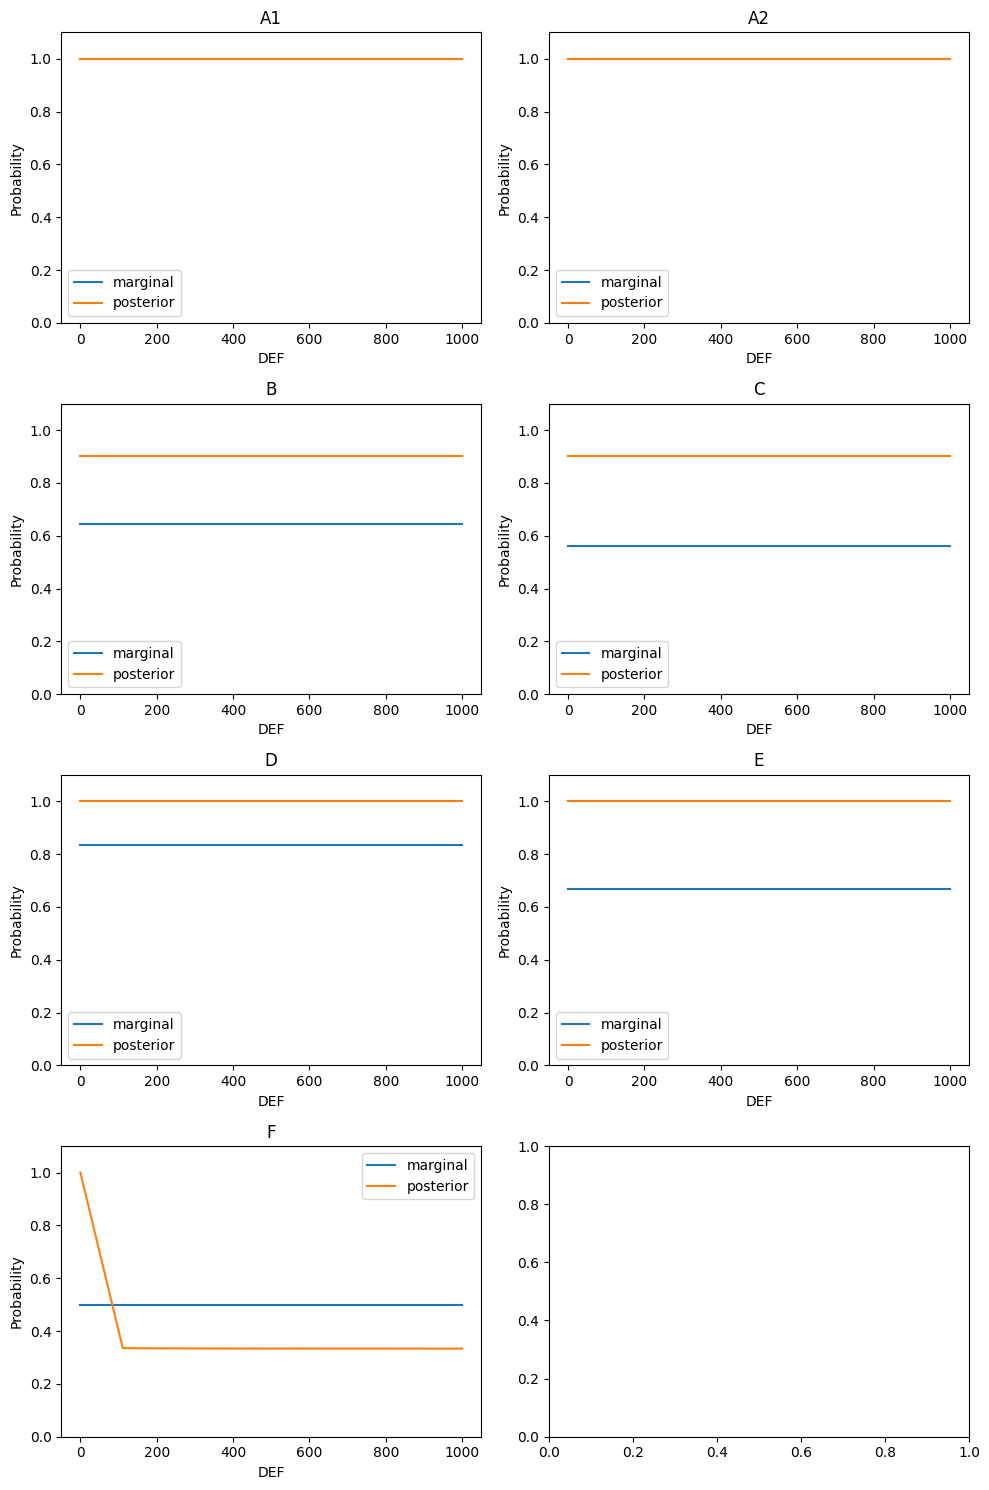

In [8]:
# dynamic 

import numpy as np
import matplotlib.pyplot as plt
import torch

# Factors for edges A1-B, A2-C, B-D, C-E
A1B = torch.tensor([[0, 0], [0.5, 0.9]])
A2C = torch.tensor([[0, 0], [0.7, 0.9]])
BD = torch.tensor([[0.5, 0.1], [0.1, 0.9]])
CD = torch.tensor([[0.5, 0.1],[0.1, 0.9]])
CE = torch.tensor([[0.5, 0.1], [0.1, 0.9]])

# Factor for the triple D-E-F
DEF = torch.tensor([[0.5, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.5]])

DEF_values = np.linspace(0, 1000, 10)
A1_marginals = []
A2_marginals = []
B_marginals = []
C_marginals= []
D_marginals = []
E_marginals = []
F_marginals = []

A1_posteriors = []
A2_posteriors = []
B_posteriors = []
C_posteriors = [] 
D_posteriors = []
E_posteriors = []
F_posteriors = []

for pv in DEF_values:
    DEF = torch.tensor([[1., pv, pv, pv], 
                        [pv, pv, pv, 1.]])
    marginals = compute_marginals(A1B, A2C, BD, CD, CE, DEF)
    posteriors = compute_posteriors(A1B, A2C, BD, CD, CE, DEF)
    A1_marginals.append(marginals['A1'][1])
    A2_marginals.append(marginals['A2'][1])
    B_marginals.append(marginals['B'][1])
    C_marginals.append(marginals['C'][1])
    D_marginals.append(marginals['D'][1])
    E_marginals.append(marginals['E'][1])
    F_marginals.append(marginals['F'][1])

    A1_posteriors.append(posteriors['A1'][1])
    A2_posteriors.append(posteriors['A2'][1])
    B_posteriors.append(posteriors['B'][1])
    C_posteriors.append(posteriors['C'][1])
    D_posteriors.append(posteriors['D'][1])
    E_posteriors.append(posteriors['E'][1])
    F_posteriors.append(posteriors['F'][1])


fig, axs = plt.subplots(4, 2, figsize=(10, 15))
ax = axs[0, 0]
ax.plot()
ax.plot(DEF_values, A1_marginals, label='marginal')
ax.plot(DEF_values, A1_posteriors, label='posterior')
ax.set_title(f'A1')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.set_ylim(0, 1.1)
ax.legend()

ax = axs[0, 1]
ax.plot(DEF_values, A2_marginals, label='marginal')
ax.plot(DEF_values, A2_posteriors, label='posterior')
ax.set_title(f'A2')
ax.set_ylim(0, 1.1)
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()

ax = axs[1, 0]
ax.plot(DEF_values, B_marginals, label='marginal')
ax.plot(DEF_values, B_posteriors, label='posterior')
ax.set_ylim(0, 1.1)
ax.set_title(f'B')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()


ax = axs[1, 1]
ax.plot(DEF_values, C_marginals, label='marginal')
ax.plot(DEF_values, C_posteriors, label='posterior')
ax.set_ylim(0, 1.1)
ax.set_title(f'C')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()


ax = axs[2, 0]
ax.plot(DEF_values, D_marginals, label='marginal')
ax.plot(DEF_values, D_posteriors, label='posterior')
ax.set_ylim(0, 1.1)
ax.set_title(f'D')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()


ax = axs[2, 1]
ax.plot(DEF_values, E_marginals, label='marginal')
ax.plot(DEF_values, E_posteriors, label='posterior')
ax.set_ylim(0, 1.1)
ax.set_title(f'E')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()


ax = axs[3, 0]
ax.plot(DEF_values, F_marginals, label='marginal')
ax.plot(DEF_values, F_posteriors, label='posterior')
ax.set_ylim(0, 1.1)
ax.set_title(f'F')
ax.set_xlabel('DEF')
ax.set_ylabel('Probability')
ax.legend()


plt.tight_layout()
plt.show()


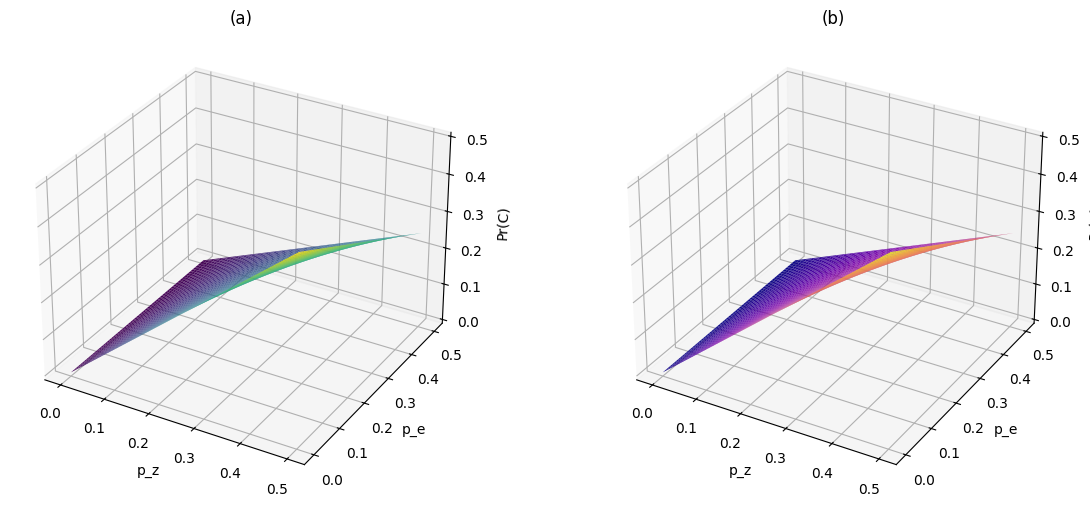

In [6]:


# Generate data: ranges for p_z and p_e
p_z = np.linspace(0, 0.5, 100)  # Adjust according to your data range
p_e = np.linspace(0, 0.5, 100)  # Adjust according to your data range

# Create meshgrid for plotting
Pz, Pe = np.meshgrid(p_z, p_e)

# Hypothetical function for Pr(C), replace with your actual function
# For example, let's assume Pr(C) = p_z * (1 - p_e) for demonstration purposes
Pr_C = Pz * (1 - Pe)

# Create a figure for plotting
fig = plt.figure(figsize=(14, 6))

# Create the first subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(Pz, Pe, Pr_C, cmap='viridis')
ax1.set_title('(a)')
ax1.set_xlabel('p_z')
ax1.set_ylabel('p_e')
ax1.set_zlabel('Pr(C)')

# Create the second subplot (you might have a different function or configuration for this)
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(Pz, Pe, Pr_C, cmap='plasma')  # Using a different colormap for variation
ax2.set_title('(b)')
ax2.set_xlabel('p_z')
ax2.set_ylabel('p_e')
ax2.set_zlabel('Pr(C)')

# Show the plots
plt.show()